In [1]:
from transformers import BertModel,BertTokenizer,AdamW,get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

df = pd.read_csv("C:/nlp_projects/iran_youtubecomments/iran.csv",delimiter=',')
df.head(10)

cuda


,Comments,label
0,How to stop the war Stop the media escalating it,1
1,WW1 : History Books WW2 : History Books WW3 : ...,1
2,Let the politicians go to war and soldiers tak...,1
3,We'll be praying for the peace of everyone.......,1
4,We are praying that this won't go too far. Ble...,1
5,This year is going to be interesting,1
6,USA vs Iran = Iraq suffers War freaks should f...,1
7,Sort it out like men. Have a boxing match inst...,1
8,3:00 - She said “I hope the revenge continues....,1
9,They shot that plane down the evidence is in i...,1


Comments    1
label       0
dtype: int64
9


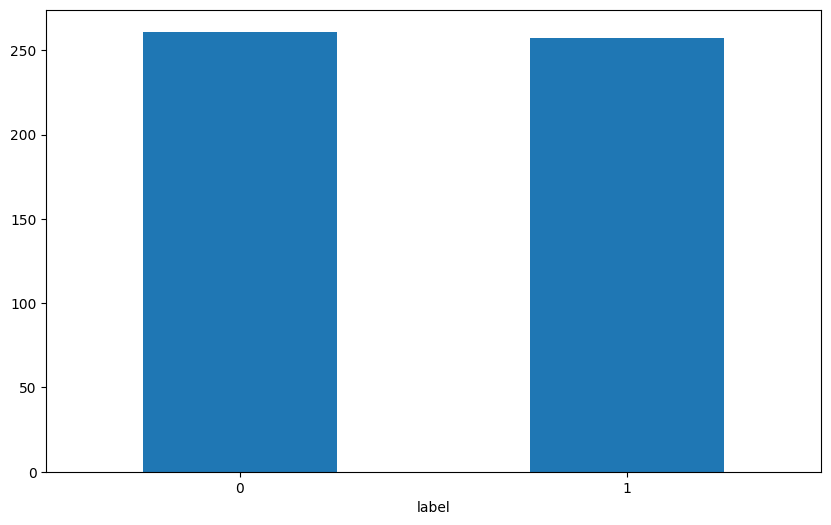

In [2]:
print(df.isnull().sum())
df['Comments'] = df['Comments'].fillna("")
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)


plt.figure(figsize=(10,6))
df['label'].value_counts().plot(kind='bar',rot=0)
plt.show()


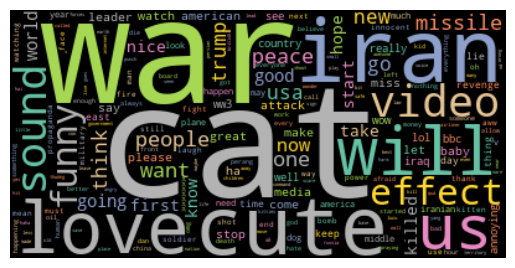

In [3]:


df['Comments'] = df['Comments'].str.lower()



def expand_contractions(text):
    return contractions.fix(text)



df['Comments'] = df['Comments'].apply(expand_contractions)


## removing stopwords




df['Comments'] = df['Comments'].str.replace('"','')

sample_txt = " ".join(i for i in df['Comments'])

wc = WordCloud(colormap="Set2",collocations=False).generate(sample_txt)
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<Figure size 1000x600 with 0 Axes>

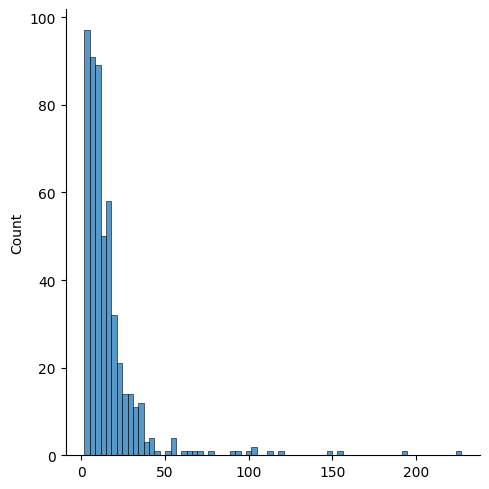

In [4]:
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME,do_lower_case=True)



sample_tokens= []
for txt in df['Comments']:
    tokens = tokenizer.encode(txt,max_length=512)
    sample_tokens.append(len(tokens))


plt.figure(figsize=(10,6))
sns.displot(sample_tokens)
plt.show()

In [9]:
MAX_LEN = 200

class youtube_dataset:
    def __init__(self,Comments,targets,tokenizer,max_len):
        self.Comments = Comments
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.Comments)
    
    def __getitem__(self,idx):
        Comments = str(self.Comments[idx])
        target = self.targets[idx]
        
        
        encoding= self.tokenizer.encode_plus(
            Comments,
            max_length=self.max_len,
            padding="max_length",
            return_attention_mask=True,
            add_special_tokens=True,
            truncation=True,
            return_token_type_ids=False,
            return_tensors="pt",
            )
        
        return {
        "Comments":Comments,
        "input_ids":encoding['input_ids'].flatten(),
        "attention_mask":encoding['attention_mask'].flatten(),
        "targets":torch.tensor(target,dtype=torch.long)
        }
    
    


from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df,test_size=.20,random_state=42)
df_val,df_test = train_test_split(df_test,test_size=.50,random_state=42)






def get_dataloader(df,tokenizer,max_len,batch_size):
    ds = youtube_dataset(
        Comments = df['Comments'].to_numpy(),
        targets = df['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
        )
    return torch.utils.data.DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
        )



BATCH_SIZE = 16
learning_rate = 2e-5


train_dataloader = get_dataloader(df_train, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)
test_dataloader = get_dataloader(df_test,tokenizer=tokenizer,max_len=MAX_LEN,batch_size=BATCH_SIZE)
val_dataloader = get_dataloader(df_val, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)


data = next(iter(train_dataloader))
print(data.keys())
data['input_ids'].shape,data['attention_mask'].shape,data['attention_mask'].shape



dict_keys(['Comments', 'input_ids', 'attention_mask', 'targets'])


(torch.Size([16, 200]), torch.Size([16, 200]), torch.Size([16, 200]))

In [10]:

class Bert_Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Bert_Classifier,self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)



model = Bert_Classifier(2)
model.to(device)

Bert_Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [11]:
num_epochs = 4
total_steps = len(train_dataloader) * num_epochs


optimizer = AdamW(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss().to(device)
scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)




def training_epoch(model,dataloader,loss_fn,optimizer,device,scheduler,n_examples):
    model.train()
    losses = []
    predictions = 0
    for d in dataloader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        outputs = model(
            attention_mask=attention_mask,
            input_ids=input_ids
            )
        _,preds = torch.max(outputs,dim=1)
        loss = loss_fn(outputs,targets)
        predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return (predictions.double() / n_examples,np.mean(losses))



def eval_model(model,dataloader,loss_fn,device,n_examples):
    model.eval()
    losses = []
    predictions = 0
    
    
    with torch.no_grad():
        for d in dataloader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                attention_mask=attention_mask,
                input_ids=input_ids
                )
            
            _,preds = torch.max(outputs,dim=1)
            loss = loss_fn(outputs,targets)
            
            predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
        return (predictions.double() / n_examples,np.mean(losses))






for epoch in range(num_epochs):
    print(f'{epoch+1}/{num_epochs}')
    
    train_acc,train_loss = training_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
        )
    
    
    val_acc,val_loss = eval_model(model, val_dataloader, loss_fn, device, len(df_val))
    print(f" Training accuracy {train_acc*100:.2f}%; -Val Accuracy-- {val_acc*100:.2f}%")
    print(f"training loss {train_loss*100:.2f}%; --val loss-- {val_loss*100:.2f}%")




test_acc, _ = eval_model(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(df_test)
)

print(f'Testing Accuracy : {test_acc.item() *100 :.2f}%')

1/4
 Training accuracy 66.18%; -Val Accuracy-- 86.54%
training loss 61.09%; --val loss-- 49.95%
2/4
 Training accuracy 89.61%; -Val Accuracy-- 84.62%
training loss 38.12%; --val loss-- 32.36%
3/4
 Training accuracy 94.93%; -Val Accuracy-- 86.54%
training loss 21.41%; --val loss-- 28.71%
4/4
 Training accuracy 96.62%; -Val Accuracy-- 86.54%
training loss 14.93%; --val loss-- 27.84%
Testing Accuracy : 88.46%


Classification Report:               precision    recall  f1-score   support

           0       0.89      0.89      0.89        28
           1       0.88      0.88      0.88        24

    accuracy                           0.88        52
   macro avg       0.88      0.88      0.88        52
weighted avg       0.88      0.88      0.88        52



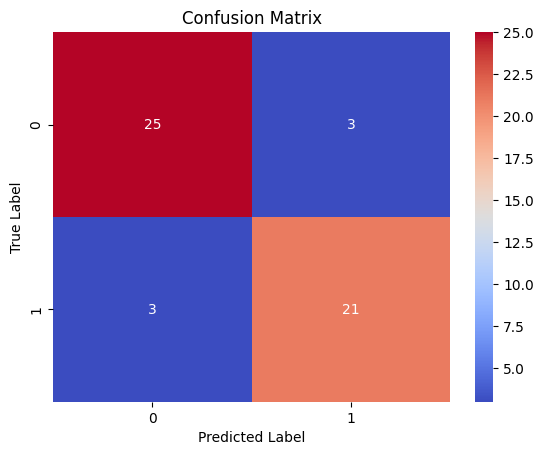

In [12]:
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for d in dataloader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                attention_mask=attention_mask,
                input_ids=input_ids
            )
            
            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    return all_labels, all_preds





true_labels, predicted_labels = get_predictions(model, test_dataloader, device)

clf_rpt = classification_report(true_labels,predicted_labels)
print(f'Classification Report: {clf_rpt}')




def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


plot_confusion_matrix(true_labels, predicted_labels)
